# <a id="2">Load packages</a>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os



# <a id="3">Read the data</a>

In [3]:
data_df = pd.read_csv("../input/w06-training/W06_training.txt",sep=';')

# <a id="4">Check the data</a>

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 300000  columns: 8


## <a id="41">Glimpse the data</a>

looking to the data features (first 5 rows).

In [5]:
data_df.head()

,LevelOfTrust,ScanTimeInSeconds,TotalBasketValue,ScannedProducts,CountOfVoidedScans,ActivateWithoutScan,ModifiedQuantities,Fraud
0,2,1401,58.83,17,2,7,1,0
1,2,655,57.20,6,7,1,4,0
2,4,770,36.00,28,11,3,4,0
3,5,272,89.76,1,4,0,2,0
4,6,1511,8.75,15,0,7,4,0


Let's look into more details to the data.

In [6]:
data_df.describe()

,LevelOfTrust,ScanTimeInSeconds,TotalBasketValue,ScannedProducts,CountOfVoidedScans,ActivateWithoutScan,ModifiedQuantities,Fraud
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,3.504080,915.245477,50.005572,15.479810,5.495613,5.002803,2.496583,0.047760
std,1.707825,529.392082,28.936956,8.667783,3.446403,3.164196,1.708467,0.213258
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,457.000000,24.960000,8.000000,3.000000,2.000000,1.000000,0.000000
50%,4.000000,915.000000,50.010000,15.000000,5.000000,5.000000,2.000000,0.000000
75%,5.000000,1372.000000,74.980000,23.000000,8.000000,8.000000,4.000000,0.000000
max,6.000000,1921.000000,104.920000,30.000000,11.000000,10.000000,5.000000,1.000000


## <a id="42">Check missing data</a>  

check if there is any missing data.

In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,LevelOfTrust,ScanTimeInSeconds,TotalBasketValue,ScannedProducts,CountOfVoidedScans,ActivateWithoutScan,ModifiedQuantities,Fraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

check data unbalance with respect with *target* value, i.e. **Class**.

In [8]:
data_df = data_df.rename(columns={'Fraud': 'Class'})


data_df["Class"].value_counts()

0    285672
1     14328
Name: Class, dtype: int64

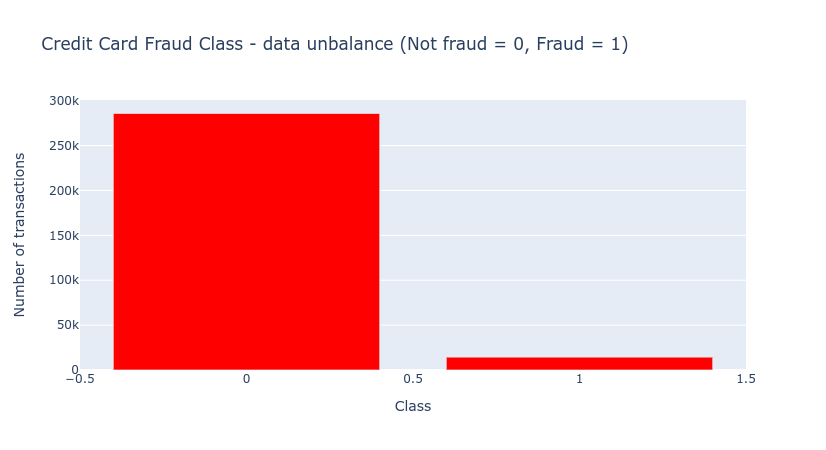

In [9]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# <a id="5">Data exploration</a>

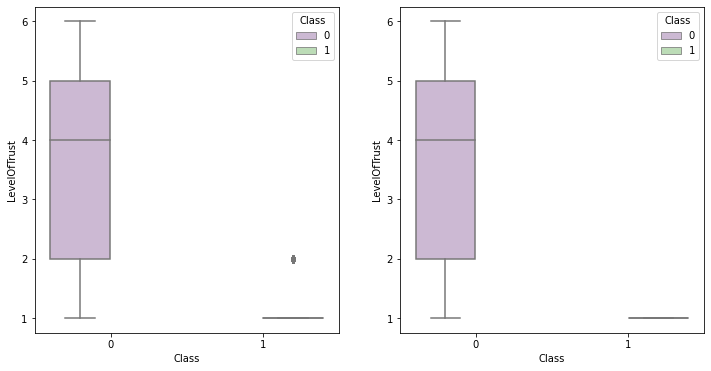

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="LevelOfTrust", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="LevelOfTrust", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [11]:
tmp = data_df[['LevelOfTrust','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['LevelOfTrust']
class_1 = tmp.loc[tmp['Class'] == 1]['LevelOfTrust']
class_0.describe()

count    285672.000000
mean          3.618808
std           1.666987
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: LevelOfTrust, dtype: float64

In [12]:
class_1.describe()

count    14328.000000
mean         1.216639
std          0.411969
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: LevelOfTrust, dtype: float64

## Features correlation

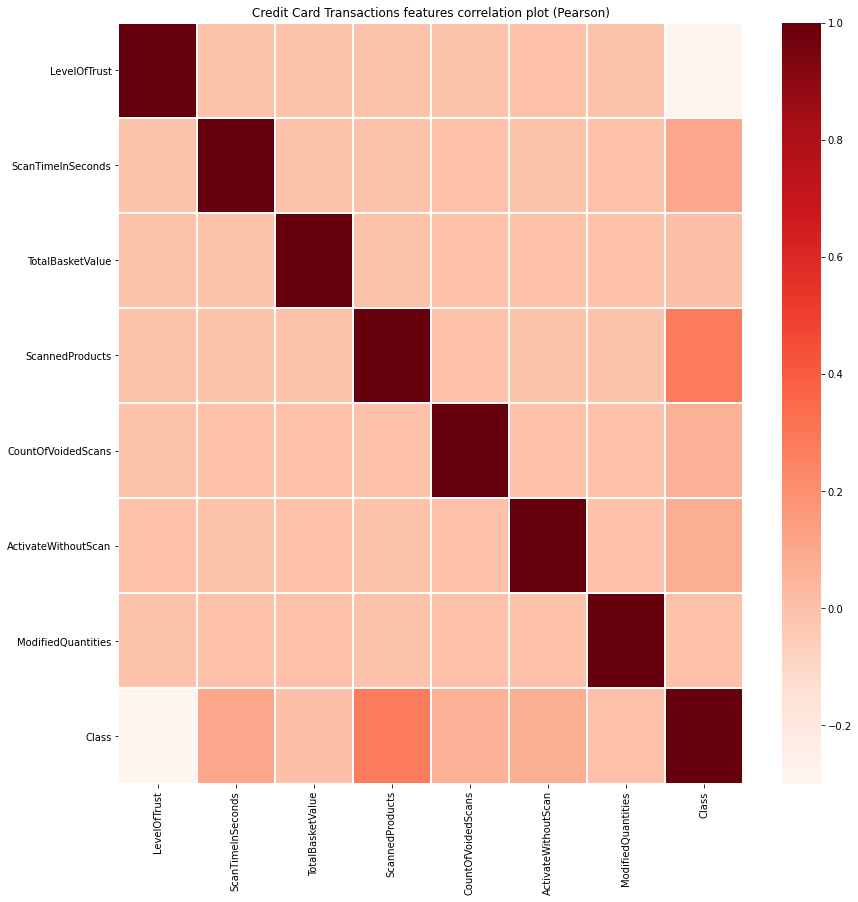

In [13]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

## Features density plot

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parame

<Figure size 432x288 with 0 Axes>

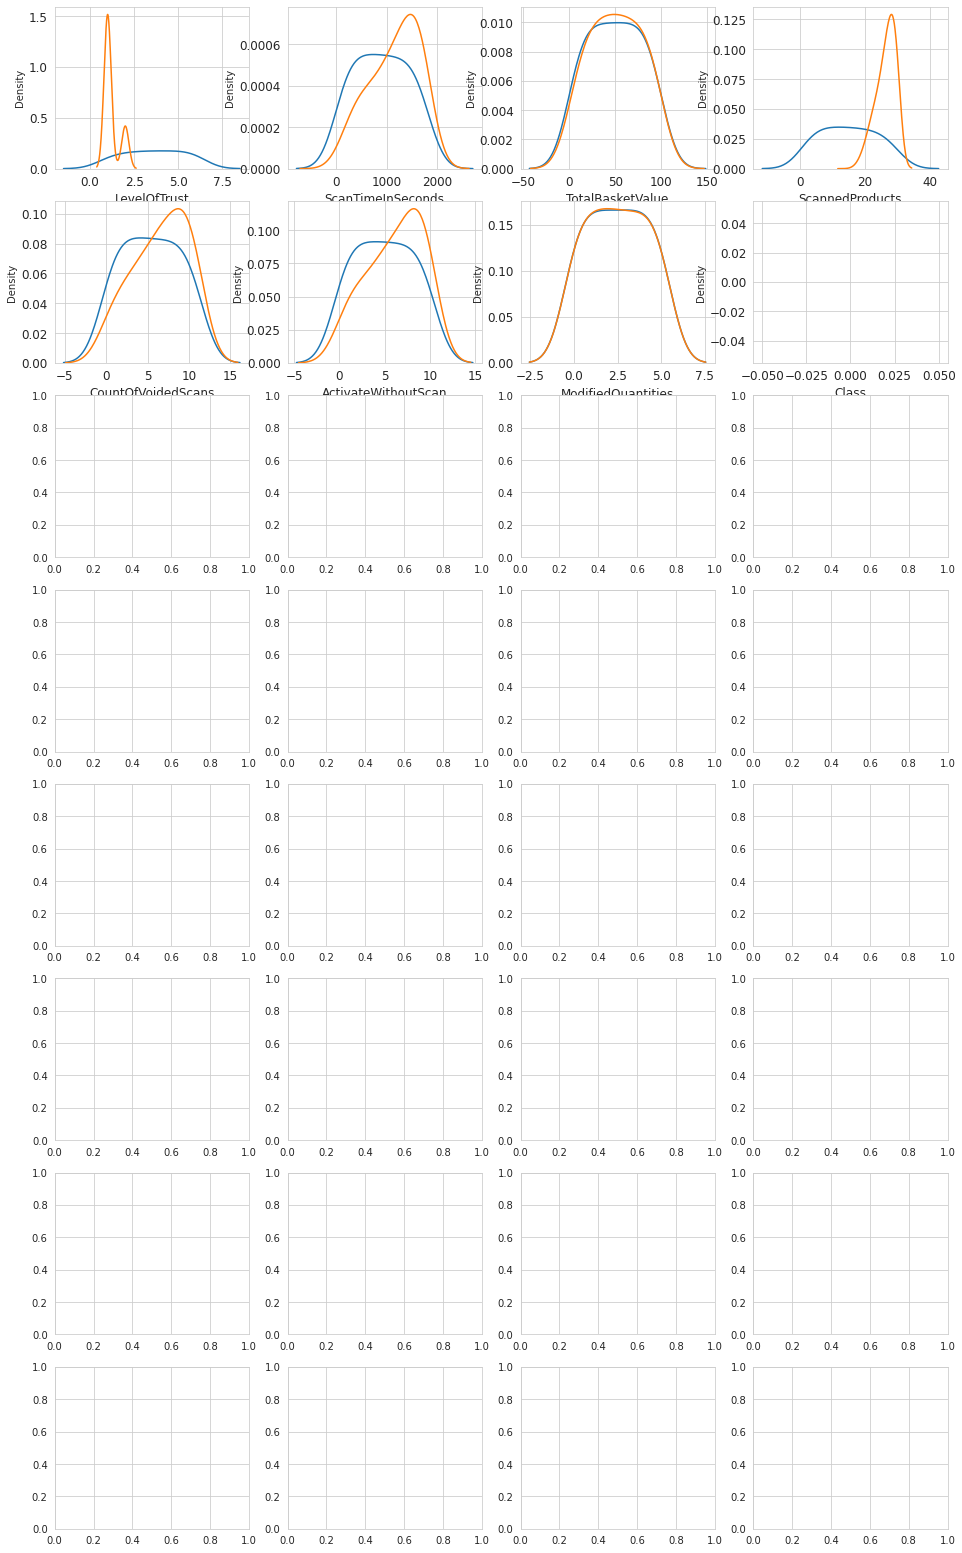

In [14]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [15]:
data_df.columns

Index(['LevelOfTrust', 'ScanTimeInSeconds', 'TotalBasketValue',
       'ScannedProducts', 'CountOfVoidedScans', 'ActivateWithoutScan',
       'ModifiedQuantities', 'Class'],
      dtype='object')

In [16]:
target = 'Class'
predictors = ['LevelOfTrust', 'ScanTimeInSeconds', 'TotalBasketValue',
       'ScannedProducts', 'CountOfVoidedScans', 'ActivateWithoutScan',
       'ModifiedQuantities']

SCALING THE DATA

In [17]:
data_df[predictors] = data_df[predictors].apply(lambda x: x / x.max())

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [18]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## <a id="61">RandomForestClassifier</a>


### Define model parameters

Let's set the parameters for the model.

In [19]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [20]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **valid_df** data, using **predict** function.

In [21]:
preds = clf.predict(valid_df[predictors])

Let's also visualize the features importance.

### Features importance

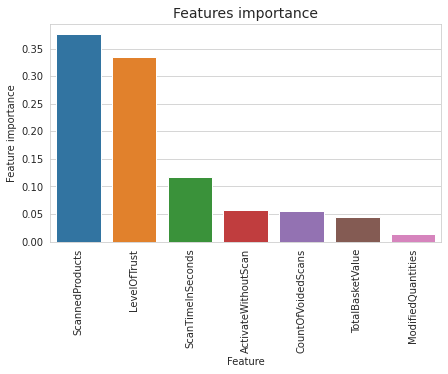

In [22]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

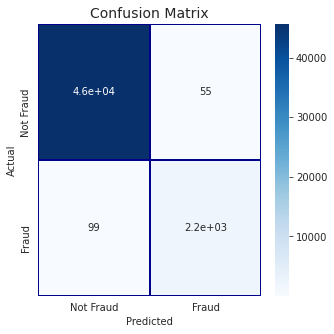

In [23]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(valid_df[target].values, preds, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45678
       Fraud       0.98      0.96      0.97      2322

    accuracy                           1.00     48000
   macro avg       0.99      0.98      0.98     48000
weighted avg       1.00      1.00      1.00     48000



In [25]:
roc_auc_score(valid_df[target].values, preds)

0.9780801301730924

## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier stands for Adaptive Boosting Classifier <a href='#8'>[5]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [26]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Fit the model

Let's fit the model.

In [27]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

### Predict the target values

Let's now predict the **target** values for the **valid_df** data, using predict function.

In [28]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

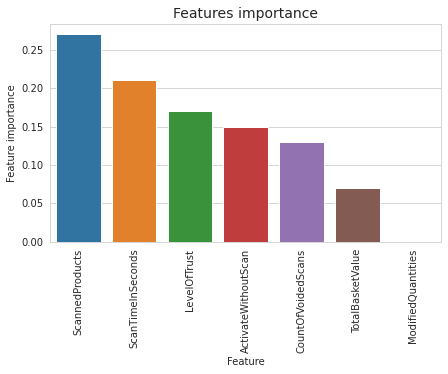

In [29]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

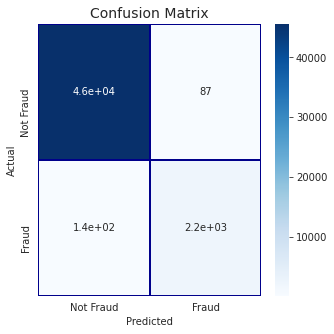

In [30]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [31]:
roc_auc_score(valid_df[target].values, preds)

0.969762582544727

In [32]:
from sklearn.metrics import classification_report
print(classification_report(valid_df[target].values, preds, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45678
       Fraud       0.96      0.94      0.95      2322

    accuracy                           1.00     48000
   macro avg       0.98      0.97      0.97     48000
weighted avg       1.00      1.00      1.00     48000



## <a id="63">CatBoostClassifier</a>


CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [33]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [34]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 210ms	remaining: 1m 44s
50:	total: 8.02s	remaining: 1m 10s
100:	total: 17.1s	remaining: 1m 7s
150:	total: 25.3s	remaining: 58.4s
200:	total: 33.3s	remaining: 49.6s
250:	total: 40.6s	remaining: 40.3s
300:	total: 48.8s	remaining: 32.3s
350:	total: 56.3s	remaining: 23.9s
400:	total: 1m 3s	remaining: 15.7s
450:	total: 1m 11s	remaining: 7.72s
499:	total: 1m 19s	remaining: 0us


### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [35]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

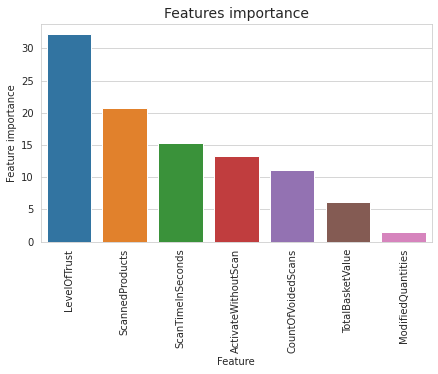

In [36]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

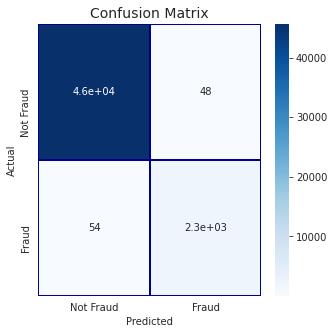

In [37]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [38]:
roc_auc_score(valid_df[target].values, preds)

0.9878466759734725

In [39]:
from sklearn.metrics import classification_report
print(classification_report(valid_df[target].values, preds, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     45678
       Fraud       0.98      0.98      0.98      2322

    accuracy                           1.00     48000
   macro avg       0.99      0.99      0.99     48000
weighted avg       1.00      1.00      1.00     48000



## <a id="63">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [40]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model. 

In [41]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[21:40:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.95480	valid-auc:0.95472
[50]	train-auc:0.98862	valid-auc:0.98969
[100]	train-auc:0.99225	valid-auc:0.99317
[150]	train-auc:0.99630	valid-auc:0.99694
[200]	train-auc:0.99816	valid-auc:0.99855
[250]	train-auc:0.99880	valid-auc:0.99906
[300]	train-auc:0.99913	valid-auc:0.99929
[350]	train-auc:0.99934	valid-auc:0.99942
[400]	train-auc:0.99945	valid-auc:0.99948
[450]	train-auc:0.99953	valid-auc:0.99952
[500]	train-auc:0.99958	valid-auc:0.99954
[550]	train-auc:0.99964	valid-auc:0.99955
[600]	train-auc:0.99968	valid-auc:0.99956
[650]	train-auc:0.99972	valid-auc:0.99957
[700]	train-auc:0.99975	valid-auc:0.99957
[750]	train-auc:0.99976	valid-auc:0.99957
[77

### Plot variable importance

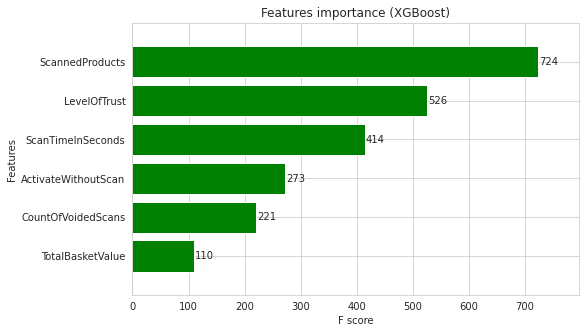

In [42]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### Predict test set


We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [43]:
preds = model.predict(dtest)

### Area under curve

Let's calculate ROC-AUC.

In [44]:
roc_auc_score(test_df[target].values, preds)

0.9997727715136163

## <a id="64">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[8]</a> <a href='#8'>[9]</a>.


### Define model parameters

Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [45]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

### Prepare the model

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

In [46]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Run the model

Let's run the model, using the **train** function.

In [47]:
evals_results = {}

model_lightgbm = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017744 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.994916	valid's auc: 0.995448
[100]	train's auc: 0.997057	valid's auc: 0.997421
[150]	train's auc: 0.998914	valid's auc: 0.999126
[200]	train's auc: 0.999427	valid's auc: 0.999498
[250]	train's auc: 0.999637	valid's auc: 0.999642
[300]	train's auc: 0.99972	valid's auc: 0.999694
[350]	train's auc: 0.999759	valid's auc: 0.999719
[400]	train's auc: 0.999787	valid's auc: 0.999735
[450]	train's auc: 0.99981	valid's auc: 0.999747
[500]	train's auc: 0.999827	valid's auc: 0.999762
[550]	train's auc: 0.999847	valid's auc: 0.999778
[600]	train's auc: 0.999858	valid's auc: 0.999789
[650]	train's auc: 0.999868	valid's auc: 0.999799
[700]	train's auc: 0.999872	valid's auc: 0.999804
[750]	train's auc: 0.999878	valid's auc: 0.999809
[800]	train's auc: 0.99988

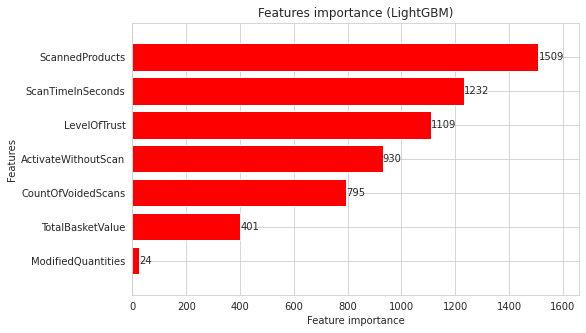

In [48]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model_lightgbm, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

Let's predict now the target for the test data.

### Predict test data

In [49]:
preds = model_lightgbm.predict(test_df[predictors])

### Area under curve

Let's calculate the ROC-AUC score for the prediction.

In [50]:
roc_auc_score(test_df[target].values, preds)

0.9998340339447462

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions 

In [51]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)                                    

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.997266	valid_1's auc: 0.997278
[100]	training's auc: 0.998057	valid_1's auc: 0.997995
[150]	training's auc: 0.998493	valid_1's auc: 0.998449
[200]	training's auc: 0.998794	valid_1's auc: 0.998738
[250]	training's auc: 0.999017	valid_1's auc: 0.998954
[300]	training's auc: 0.999164	valid_1's auc: 0.999098
[350]	training's auc: 0.999268	valid_1's auc: 0.999199
[400]	training's auc: 0.999341	valid_1's auc: 0.999269
[450]	training's auc: 0.999385	valid_1's auc: 0.99931
[500]	training's auc: 0.999422	valid_1's auc: 0.999341
[550]	training's auc: 0.999443	valid_1's auc: 0.99936
[600]	training's auc: 0.999465	valid_1's auc: 0.999384
[650]	training's auc: 0.99948	valid_1's auc: 0.999393
[700]	training's auc: 0.999493	valid_1's auc: 0.999403
[750]	training's auc: 0.999503	valid_1's auc: 0.99941

In [52]:
pred = test_preds

In [53]:
roc_auc_score(test_df[target].values, pred)

0.999635536275737

# SINCE LIGHTGBM IS THE BEST MODEL WE WILL USE IT THEN TO PREDICT THE 100000 NEW ROWS

In [54]:
df_test = pd.read_csv("../input/w06-scoring/W06_scoring.txt",sep =';')

In [55]:
df_test  = df_test.apply(lambda x: x / x.max())

In [56]:
preds = model_lightgbm.predict(df_test)

In [57]:
preds

array([1.58623136e-20, 5.85477898e-19, 1.33018353e-16, ...,
       3.48891994e-21, 1.53611521e-16, 2.26904245e-10])

In [58]:
df_test['predictions'] = preds

In [62]:
_preds = list()
for i in df_test['predictions'] : 
    if i < 0.5:
        _preds.append(0)
    else : 
        _preds.append(1) 
        
        
df_test['predictions']= _preds

In [63]:
df_test['predictions'].value_counts()

0    93765
1     6235
Name: predictions, dtype: int64

# Calculation costs

using the classification report and the recall, precision, f1 score and accruacy you can calculate the costs.

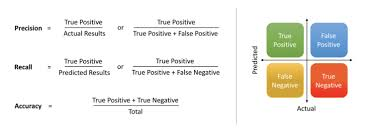

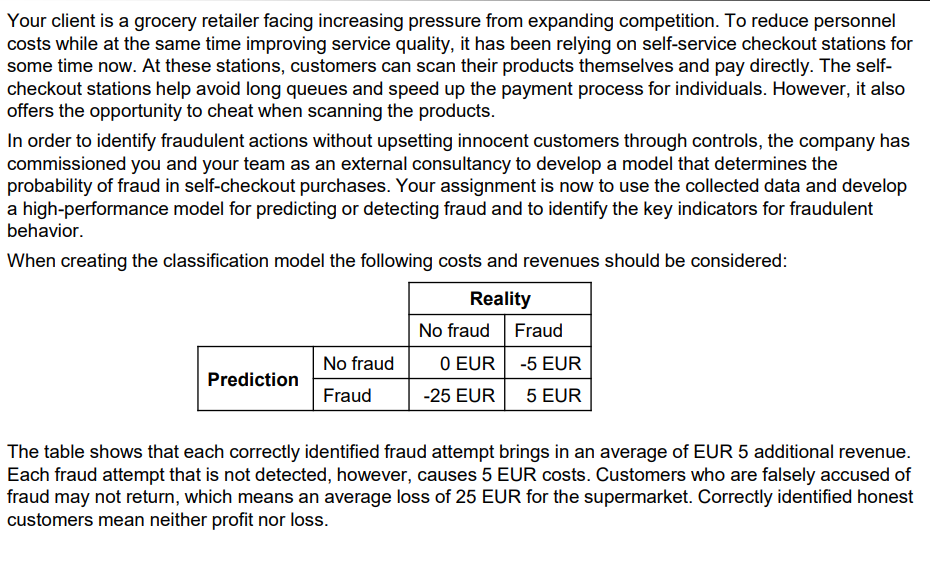
